## Calculate emission spectrum with/without various absorbers
This loads the netCDF output file from the `out` folder, and recalculates the radiative transfer with absorbers removed one at a time.

In [1]:
# Import system packages
using Printf
using Plots
using LaTeXStrings
using NCDatasets
using DataStructures

In [2]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../"))

"/home/n/nichollsh/AGNI/"

In [3]:
# Import AGNI
using AGNI
import AGNI.atmosphere as atmosphere
import AGNI.energy as energy
import AGNI.dump as dump
import AGNI.plotting as plotting
import AGNI.setpt as setpt

# Disable logging from AGNI module
AGNI.setup_logging("",1)

### Locate folder

In [4]:
output_dir = joinpath(ROOT_DIR, "out")

# use same spectral file as simulation
# spectral_file = joinpath(output_dir, "runtime.sf")
# star_file = ""

# use high resolution file
spectral_file = joinpath(ENV["FWL_DATA"], "spectral_files/Honeyside/4096/Honeyside.sf")
star_file = joinpath(ROOT_DIR, "res/stellar_spectra/sun.txt")

"/home/n/nichollsh/AGNI/res/stellar_spectra/sun.txt"

### Read information from netCDF file

In [5]:
# Open file
# fpath = joinpath(output_dir, "atm.nc")
fpath = "nogit_6716000_atm.nc"
if !isfile(fpath)
    error("The file '$fpath' does not exist")
end
ds = Dataset(fpath,"r")


# Get all of the information that we need
nlev_c::Int = length(ds["p"][:])

#   temperature arrays
input_tmpl::Array{Float64,1} = ds["tmpl"][:]
input_tmp::Array{Float64,1}  = ds["tmp"][:]

#   pressure arrays
input_pl::Array{Float64,1} = ds["pl"][:]
input_p::Array{Float64,1}  = ds["p"][:]

#   gas names
raw_gases::Array{Char,2} = ds["gases"][:,:]
num_gas::Int = size(raw_gases)[2]
input_gases::Array{String,1} = []
for i in 1:num_gas
    push!(input_gases, strip(String(raw_gases[:,i])))
end

# gas VMRs
raw_vmrs::Array{Float64, 2} = ds["x_gas"][:,:]
input_vmrs::Dict{String, Array{Float64,1}} = Dict()      # dict of Arrays
input_vmrs_scalar::Dict{String, Float64} = Dict()        # dict of Floats (surface values)
for i in 1:num_gas
    g = input_gases[i]
    input_vmrs[g]     = zeros(Float64, nlev_c)
    input_vmrs[g][:] .= raw_vmrs[i, :]

    input_vmrs_scalar[g] = input_vmrs[g][end]
end

# surface
input_tsurf::Float64   = ds["tmp_surf"][1]
input_radius::Float64  = ds["planet_radius"][1]
input_gravity::Float64 = ds["surf_gravity"][1]

# stellar properties
input_inst::Float64   = ds["instellation"][1]
input_s0fact::Float64 = ds["inst_factor"][1]
input_albedo::Float64 = ds["bond_albedo"][1]
input_zenith::Float64 = ds["zenith_angle"][1]

# flags
input_flag_rayleigh::Bool  = Bool(ds["flag_rayleigh"][1] == 'y')
input_flag_thermo::Bool    = Bool(ds["thermo_funct"][1] == 'y')
input_flag_continuum::Bool = Bool(ds["flag_continuum"][1] == 'y')

# Close file
close(ds);


In [7]:
# display(input_vmrs)

# get surface vmrs as an array
_gas_surfs::Array{Float64,1} = []
for g in input_gases
    push!(_gas_surfs, input_vmrs_scalar[g])
end

# get sorted mask
gas_mask = reverse(sortperm(_gas_surfs))
;

In [8]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir,
                        spectral_file,
                        input_inst, input_s0fact, input_albedo, input_zenith,
                        input_tsurf,
                        input_gravity, input_radius,
                        nlev_c, input_pl[end], input_pl[1],
                        input_vmrs_scalar, "",
                        flag_gcontinuum=input_flag_continuum,
                        flag_rayleigh=input_flag_rayleigh,
                        thermo_functions=input_flag_thermo,
                        overlap_method=2
                        )
atmosphere.allocate!(atmos, star_file)

[ INFO  ] Composition set by dict 
[ INFO  ] Found FastChem executable 
[ INFO  ] Inserting stellar spectrum and Rayleigh coefficients 
[ INFO  ] Allocated atmosphere with composition: 
[ INFO  ]       1 N2      3.94e-03  
[ INFO  ]       2 CO      1.61e-01  
[ INFO  ]       3 CH4     7.71e-10  
[ INFO  ]       4 S2      1.61e-04 (NO_OPACITY) 
[ INFO  ]       5 SO2     2.23e-03  
[ INFO  ]       6 H2O     5.00e-02  
[ INFO  ]       7 CO2     7.80e-01  
[ INFO  ]       8 H2      2.31e-03  


true

In [9]:
atmos.tmpl[:] .= input_tmpl[:]
atmos.tmp[:] .= input_tmp[:]

atmos.pl[:] .= input_pl[:]
atmos.p[:] .= input_p[:]

for g in input_gases
    atmos.gas_vmr[g][:] .= input_vmrs[g]
end

atmosphere.calc_layer_props!(atmos)

true

### Do radtrans with different absorbers REMOVED from atmosphere

In [10]:
atm_arr = atmosphere.Atmos_t[]

for (i,g) in enumerate(input_gases)
    @printf("(%2d/%2d) Running radtrans without '%s' \n",i, num_gas, g)

    # set all to "true" value
    for gg in input_gases
        atmos.gas_vmr[gg][:] .= input_vmrs[gg][:]
    end

    # set ONLY this gas to zero
    fill!(atmos.gas_vmr[g], 0.0)

    # DO NOT UPDATE LAYER PROPERTIES

    # reset upward fluxes (just in case)
    fill!(atmos.band_u_lw, 0.0)
    fill!(atmos.band_u_sw, 0.0)

    # do radtrans with this composition
    energy.radtrans!(atmos, true)   # LW
    energy.radtrans!(atmos, false)  # SW

    # Store result
    push!(atm_arr, deepcopy(atmos))
end

@printf("Running radtrans for all gases \n")
for g in input_gases
    atmos.gas_vmr[g][:] .= input_vmrs[g][:]
end
energy.radtrans!(atmos, true)   # LW
energy.radtrans!(atmos, false)  # SW
push!(atm_arr, deepcopy(atmos))

println("Done!")

( 1/ 8) Running radtrans without 'H2O' 
( 2/ 8) Running radtrans without 'CO2' 
( 3/ 8) Running radtrans without 'H2' 
( 4/ 8) Running radtrans without 'CH4' 
( 5/ 8) Running radtrans without 'CO' 
( 6/ 8) Running radtrans without 'N2' 
( 7/ 8) Running radtrans without 'S2' 
( 8/ 8) Running radtrans without 'SO2' 
Running radtrans for all gases 
Done!


### Write as netCDF file

In [27]:
nchars = 16
nsamps = atmos.gas_num + 1
try
    close(ds)
catch
    print("no")
end
ds = Dataset(joinpath(output_dir,"blame_emission.nc"),"c")

# Global attributes
ds.attrib["description"]        = "TOA fluxes with various gases removed"
ds.attrib["AGNI_version"]       = atmos.AGNI_VERSION
ds.attrib["SOCRATES_version"]   = atmos.SOCRATES_VERSION

#     Create dimensions
defDim(ds, "nbands", atmos.nbands)      # Number of spectral bands
defDim(ds, "nsamps", nsamps)     # Gases
defDim(ds, "nchars", nchars)            # Length of string containing gas names

#     Scalar quantities
var_specfile =  defVar(ds, "specfile" ,String, ())     # Path to spectral file when read
var_starfile =  defVar(ds, "starfile" ,String, ())     # Path to star file when read
var_specfile[1] = atmos.spectral_file
var_starfile[1] = atmos.star_file

#    Create variables
var_gas  = defVar(ds, "gas",       Char,    ("nchars","nsamps",))
var_bmin = defVar(ds, "bandmin",   Float64, ("nbands",), attrib = OrderedDict("units" => "m"))
var_bmax = defVar(ds, "bandmax",   Float64, ("nbands",), attrib = OrderedDict("units" => "m"))
var_bdl =  defVar(ds, "ba_D_LW",   Float64, ("nbands","nsamps"), attrib = OrderedDict("units" => "W m-2"))
var_bul =  defVar(ds, "ba_U_LW",   Float64, ("nbands","nsamps"), attrib = OrderedDict("units" => "W m-2"))
var_bnl =  defVar(ds, "ba_N_LW",   Float64, ("nbands","nsamps"), attrib = OrderedDict("units" => "W m-2"))
var_bds =  defVar(ds, "ba_D_SW",   Float64, ("nbands","nsamps"), attrib = OrderedDict("units" => "W m-2"))
var_bus =  defVar(ds, "ba_U_SW",   Float64, ("nbands","nsamps"), attrib = OrderedDict("units" => "W m-2"))
var_bns =  defVar(ds, "ba_N_SW",   Float64, ("nbands","nsamps"), attrib = OrderedDict("units" => "W m-2"))

# Write band edges
var_bmin[:] = atmos.bands_min
var_bmax[:] = atmos.bands_max

# Fill as empty strings
for i in 1:nsamps
    for i_char in 1:nchars
        var_gas[i_char, i] = ' '
    end
end
# Fill gas names
for i_gas in 1:nsamps-1
    gas = atm_arr[i_gas].gas_dat[input_gases[i_gas]].formula
    for i_char in 1:length(gas)
        var_gas[i_char,i_gas] = gas[i_char]
    end
end
# Last => no gases removed
for (i,c) in enumerate("None")
    var_gas[i,nsamps] = c
end

# Write spectral fluxes at TOA
for i in 1:nsamps
    for ba in 1:atmos.nbands
        var_bul[ba, i] = atm_arr[i].band_u_lw[1, ba]
        var_bdl[ba, i] = atm_arr[i].band_d_lw[1, ba]
        var_bnl[ba, i] = atm_arr[i].band_n_lw[1, ba]
        var_bus[ba, i] = atm_arr[i].band_u_sw[1, ba]
        var_bds[ba, i] = atm_arr[i].band_d_sw[1, ba]
        var_bns[ba, i] = atm_arr[i].band_n_sw[1, ba]
    end
end

close(ds)

closed Dataset

### Make plot of spectra

In [28]:
# plot parameters
fs=12
lw=1.2
la=0.8
xmin = 0.9
xmax = 5.0
ymin = 10
logx=false
logy=true
atm_lvl=1

1

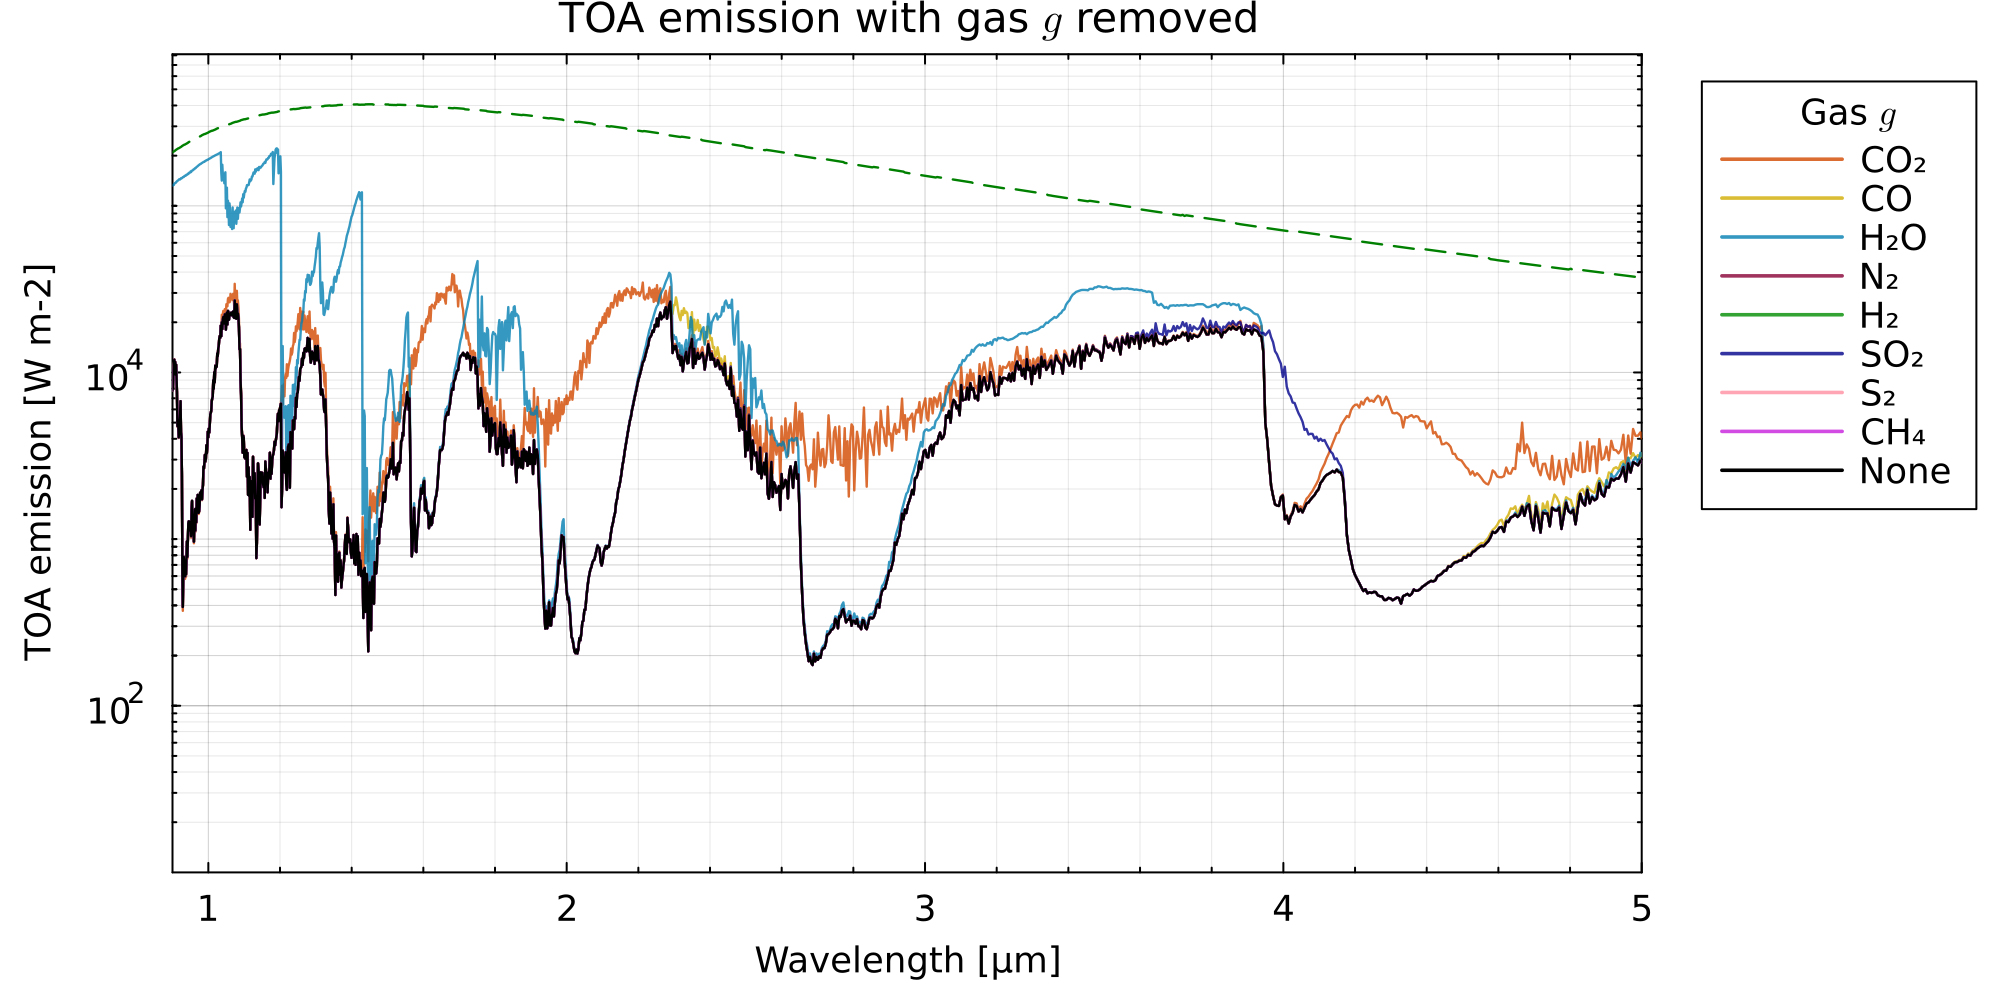

"/home/n/nichollsh/AGNI/out/blame_emission.pdf"

In [29]:
# initialise plot
if atm_lvl == 1
    title = L"TOA emission with gas $g$ removed"
else
    title = L"Upward flux (i=%$atm_lvl) with gas $g$ removed"
end

# band centres
x_arr = 0.5 * 1e6 * (atm_arr[1].bands_min + atm_arr[1].bands_max)
xlim = (max(xmin,x_arr[1]*0.98), xmax)

# band widths
w_arr = 1e6 * atm_arr[1].bands_wid

plt = Nothing
plt = plot(framestyle=:box, size=(1000,500), dpi=200,
                leg=:outertopright, legcolumn=-1,
                tickfontsize=fs, guidefontsize=fs, legendfontsize=fs,
                legendtitlefontsize=fs, leg_title=L"Gas $g$",
                left_margin = 6Plots.mm,
                bottom_margin = 6Plots.mm,
                title=title)


# PLOT surface emission + surface reflection
# dashed green line
y_arr = (atm_arr[1].band_u_lw[end,:] + atm_arr[1].band_u_sw[end,:])./w_arr[:]
plot!(plt, x_arr, y_arr, linewidth=lw, linestyle=:dash, linecolor="green", label="")

# PLOT spectrum with each gas removed
# coloured solid lines
for i in gas_mask
    this_atm = atm_arr[i]

    y_arr = (this_atm.band_u_lw[atm_lvl,:] + this_atm.band_u_sw[atm_lvl,:])./w_arr[:]

    lbl = this_atm.gas_dat[input_gases[i]].plot_label
    col = this_atm.gas_dat[input_gases[i]].plot_color

    plot!(plt, x_arr, y_arr, linewidth=lw, label=lbl, linealpha=la, linecolor=col)
end

# PLOT spectrum with all included
# black solid line
this_atm = atm_arr[end]
y_tot = (this_atm.band_u_lw[atm_lvl,:] + this_atm.band_u_sw[atm_lvl,:])./w_arr[:]
plot!(plt, x_arr, y_tot, linewidth=lw, label="None", linestyle=:solid, linecolor="black",)

xlabel!(plt, "Wavelength [µm]")
xaxis!(plt, minorgrid=true, xlims=xlim)
if logx
    xaxis!(plt, xscale=:log10)
end
ylabel!(plt, "TOA emission [W m-2]")
if logy
    yaxis!(plt, yscale=:log10)
end
yaxis!(plt, ylims=(ymin, Inf))

display(plt)
savefig(plt,joinpath(output_dir,"blame_emission.pdf"))